In [1]:
#importing required packages
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg19 import VGG19

#importing required packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology


import os
import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
from numpy import zeros, newaxis
%matplotlib inline

In [2]:
def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)
    
    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

def decoder_block(inputs, mid_channels, out_channels):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # Upsampling (nearest neighbor interpolation) layer
    db = UpSampling2D(size=(2, 2))(inputs)
    # First conv2D layer 
    db = Conv2D(mid_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db


    
    
def TransResUNet(input_size=(512, 512, 3)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)
    inp = inputs
    input_shape = input_size
    
    # Handling input channels 
    # input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(inputs)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = inputs
        input_shape = input_size

    # VGG16 with imagenet weights
    encoder = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc3)
    center = decoder_block(center, 512, 256)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, center], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)
    out = Conv2D(3, (1, 1), padding='same')(dec1)
    # Final model
    model = Model(inputs=[inputs], outputs=[out])
    
    return model

(512, 512, 1)


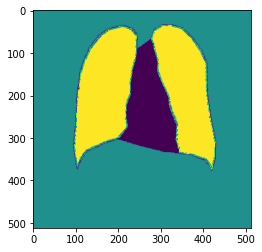

In [3]:
def preprocess_mask(mask):
    new_mask = np.zeros(shape=(512, 512, 1))
    mask_np = imageio.imread(mask).astype("float32") # (512, 512, 3)
    
    
    new_mask[np.where(mask_np[:,:,0] == 0)] = 1
    new_mask[np.where((mask_np[:,:,0] != 0) & (mask_np[:,:,0] != -1))] = 0
    
    new_mask[np.where(mask_np[:,:,0] == 128)] = 0
    new_mask[np.where((mask_np[:,:,0] != 0) & (mask_np[:,:,0] != 1))] = 0
    
    new_mask[np.where((mask_np[:,:,2] != 0) & (mask_np[:,:,2] != 1))] = 0
    new_mask[np.where(mask_np[:,:,0] == 255)] = 2
    return new_mask


image_dir = '.\\DataSet\\RY_DataSet_Aug\label\\'
image_paths = [os.path.join(image_dir, image_fname) for image_fname in os.listdir(image_dir)]
preprocessed_mask = preprocess_mask(image_paths[0])

plt.imshow(preprocessed_mask)
print(preprocessed_mask.shape)

In [4]:
input_dir = '.\\DataSet\\RY_DataSet_Aug\\xray\\'
target_dir = '.\\DataSet\\RY_DataSet_Aug\\label\\'

# sorted함수를 사용하여 정렬된 파일 리스트를 반환
# 이터러블 객체도 받을 수 있음 
image_list = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
mask_list = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])

In [5]:
# from PIL import Image

# input_dir = '.\\DataSet\\RY_DataSet_Aug\\xray\\'
# target_dir = '.\\DataSet\\RY_DataSet_Aug\\label\\'

# # sorted함수를 사용하여 정렬된 파일 리스트를 반환
# # 이터러블 객체도 받을 수 있음 
# image_list = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
# mask_list = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])


# def preprocess_image(image):
#     image_np = imageio.imread(image).astype("float32")
    
#     return cv2.resize(image_np, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

# image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image\\'
# mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask\\'
# os.makedirs(image_dir, exist_ok=True)
# os.makedirs(mask_dir, exist_ok=True)
# for image, mask in zip(image_list, mask_list):
#     image_np = preprocess_image(image)
#     image_fname = os.path.join(image_dir, os.path.basename(image))
#     cv2.imwrite(image_fname, image_np)
  
#     mask_np = preprocess_mask(mask)
#     mask_fname = os.path.join(mask_dir, os.path.basename(mask))
#     cv2.imwrite(mask_fname, mask_np)
    
  
# val_input_dir = '.\\DataSet\\RY_Test\\CXR\\'
# val_target_dir = '.\\DataSet\\RY_Test\\Label_png\\'

# val_image_list = sorted(
#     [
#         os.path.join(val_input_dir, fname)
#         for fname in os.listdir(val_input_dir)
#     ]
# )

# val_mask_list = sorted(
#     [
#         os.path.join(val_target_dir, fname)
#         for fname in os.listdir(val_target_dir)
#     ]
# )

# image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image_test\\'
# mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask_test\\'
# os.makedirs(image_dir, exist_ok=True)
# os.makedirs(mask_dir, exist_ok=True)
# for image, mask in zip(val_image_list, val_mask_list):
#     image_np = preprocess_image(image)
#     image_fname = os.path.join(image_dir, os.path.basename(image))
#     cv2.imwrite(image_fname, image_np)
                               
#     mask_np = preprocess_mask(mask)
#     mask_fname = os.path.join(mask_dir, os.path.basename(mask))
#     cv2.imwrite(mask_fname, mask_np)

In [6]:
image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image\\'
mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask\\'
image_list = sorted(
    [
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
    ])

mask_list = sorted(
    [
        os.path.join(mask_dir, fname)
        for fname in os.listdir(mask_dir)
    ])

In [7]:
val_image_dir = '.\\DataSet\\RY_DataSet_preprocess\\image_test\\'
val_mask_dir = '.\\DataSet\\RY_DataSet_preprocess\\mask_test\\'
val_image_list = sorted(
    [
        os.path.join(val_image_dir, fname)
        for fname in os.listdir(val_image_dir)
    ])

val_mask_list = sorted(
    [
        os.path.join(val_mask_dir, fname)
        for fname in os.listdir(val_mask_dir)
    ])

In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    return img, mask

dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
train_ds = dataset.map(process_path)

val_ds = tf.data.Dataset.from_tensor_slices((val_image_list, val_mask_list))
val_ds = val_ds.map(process_path)

(512, 512, 3) 255
(512, 512, 1) 2


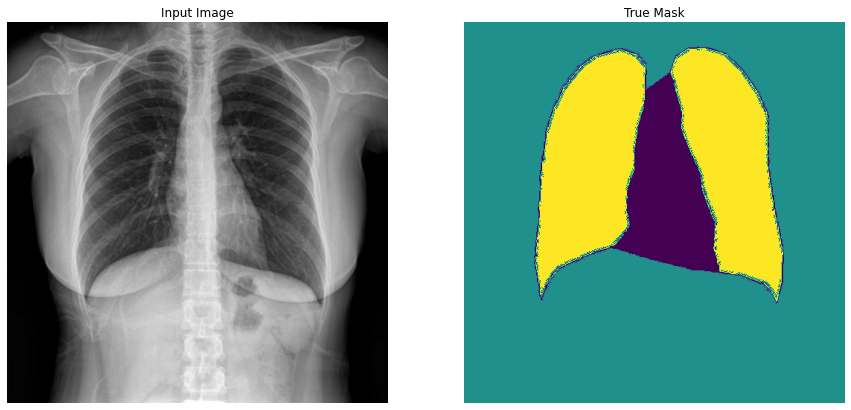

(512, 512, 3) 255
(512, 512, 1) 2


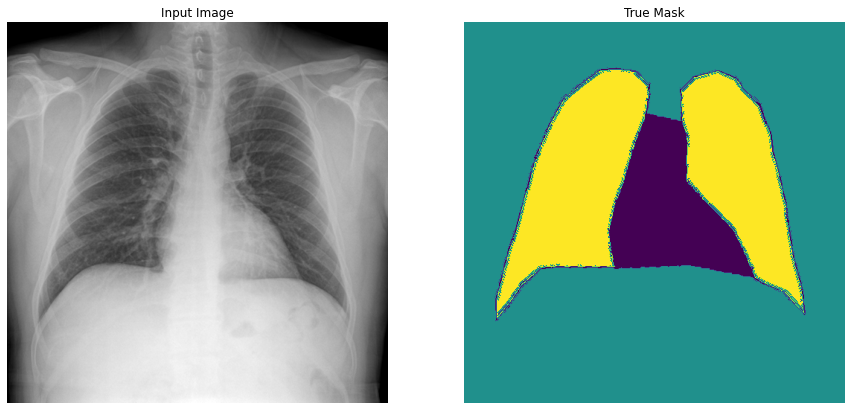

(512, 512, 3) 255
(512, 512, 1) 2


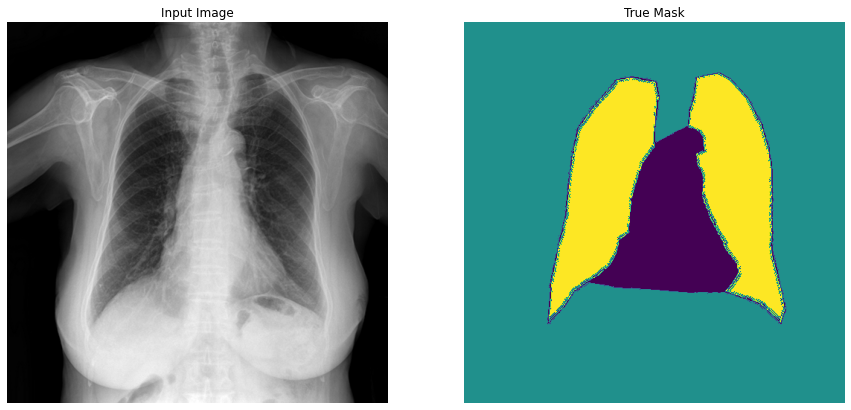

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Post Processed']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow((display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in train_ds.take(3):
    sample_image, sample_mask = image, mask
    print(image.shape, image.numpy().max())
    print(mask.shape, mask.numpy().max())

    display([sample_image, sample_mask])

(512, 512, 3) 255
(512, 512, 1) 2 0


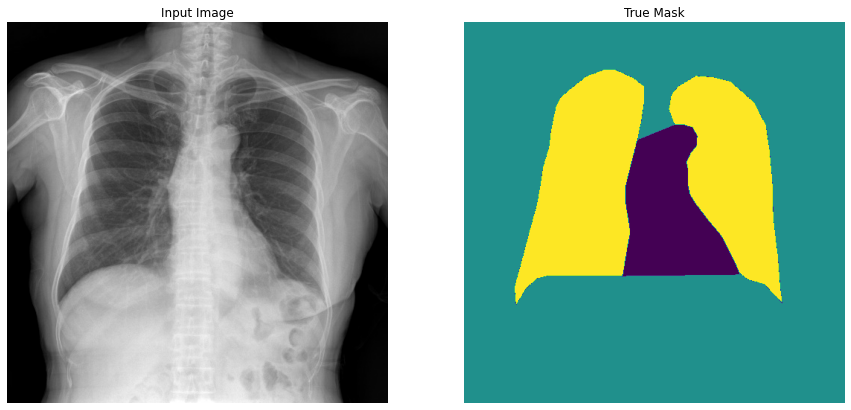

(512, 512, 3) 255
(512, 512, 1) 2 0


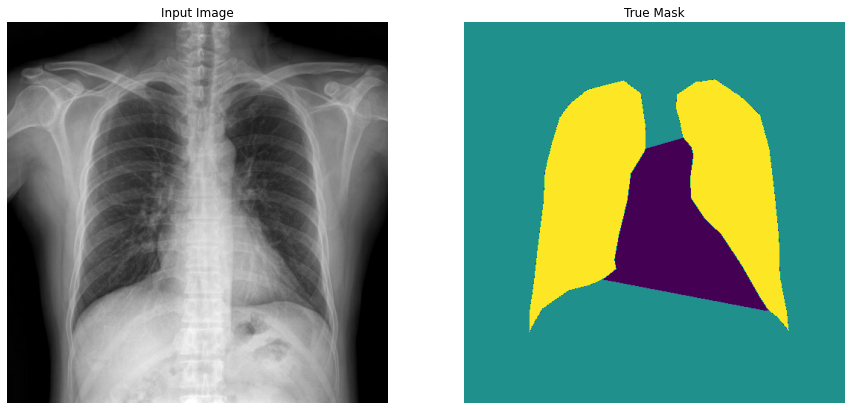

(512, 512, 3) 255
(512, 512, 1) 2 0


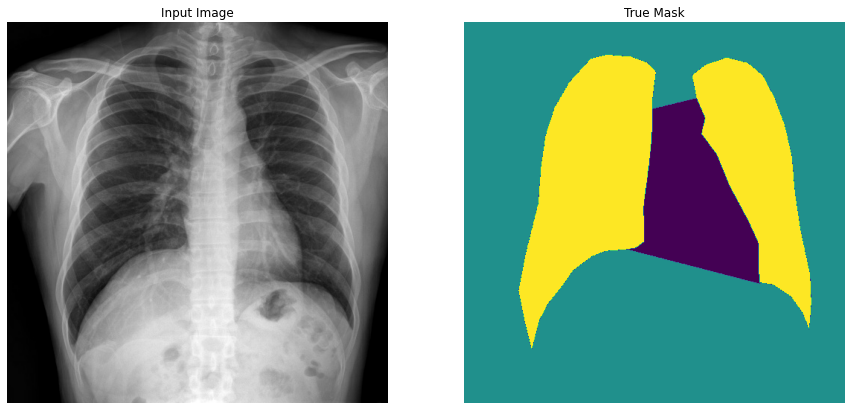

In [10]:
for image, mask in val_ds.take(3):
    sample_image, sample_mask = image, mask
    print(image.shape, image.numpy().max())
    print(mask.shape, mask.numpy().max(), mask.numpy().min())

    display([sample_image, sample_mask])

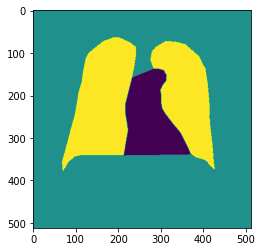

In [11]:
mask = tf.io.read_file("./DataSet\\RY_DataSet_preprocess\\mask_test\\0001.png")
mask = tf.image.decode_png(mask, channels=3)
plt.imshow(mask.numpy()[:,:,0])

In [12]:
# Call-back 함수
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

CP = ModelCheckpoint(filepath='./MODEL/VGG19-rayence-{epoch:03d}-{loss:.4f}-{accuracy:.4f}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5',
            monitor='val_loss', verbose=1, save_best_only=True, mode='min')
TB = TensorBoard(log_dir='logs', write_graph=True, write_images=True)
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=2, verbose=1, min_lr=1e-8)

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
CALLBACK = [CP, TB, LR, DisplayCallback()]

In [13]:
EPOCHS = 50
VAL_SUBSPLITS = 5
BUFFER_SIZE = 5
BATCH_SIZE = 3
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_ds.cache().batch(BATCH_SIZE)


In [14]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss(label, prediction, sample_weight).numpy()

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([5.0, 1.0, 4.0])  # 0: mediastinum, 1: background, 2: lung
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [15]:


model = TransResUNet()
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'],
             )

# model_history = model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=val_dataset,
#     callbacks = [CP, TB, LR, DisplayCallback()])

In [16]:
# class imbalance 해결방법
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb#scrollTo=UwvIKLZPtxV_

In [17]:
plt.plot(model_history.history['accuracy'], label = 'accuracy')
plt.plot(model_history.history['loss'], label = 'loss')
plt.xlabel('epochs')
plt.legend()

NameError: name 'model_history' is not defined

In [ ]:
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.legend()

In [ ]:
for val_image, val_mask in val_ds.take(1):
    break
    
predicted_mask = model(tf.expand_dims(val_image, axis=0))
predicted_mask = predicted_mask.numpy().reshape(512,512,3)

# Post-Processing for Predicted Lung Masks

In [355]:
model = TransResUNet()
model.load_weights("./MODEL/VGG19-rayence-016-0.0698-0.9715-0.0545-0.9798.hdf5")

In [448]:
def do_floodFIll(image):
    im_in = image
    th, im_th = cv2.threshold(im_in, 0, 1, cv2.THRESH_BINARY_INV)
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    retval, _image, _mask, _rect = cv2.floodFill(im_floodfill, mask, (3,3), 0)

    resized_fill_mask = cv2.resize(_mask, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    
    res_mask = resized_fill_mask.copy()
    res_mask[np.where(res_mask == 1)] = 9
    res_mask[np.where(res_mask == 0)] = 1
    res_mask[np.where(res_mask == 9)] = 0

    return res_mask

def overlay_cardiac_mask(original_mask, cardiac_mask):
    new_mask = np.zeros(shape=(512, 512))
    
    new_mask[np.where(original_mask==2)] = 2
    new_mask[np.where(cardiac_mask == 1)] = 1
    return new_mask

def convert_to_3channel(image, original_size):
    
    new_image = np.zeros(shape=(*original_size, 3), dtype=np.uint8)
    
    resize_original_image = cv2.resize(image, dsize=original_size, interpolation=cv2.INTER_CUBIC)
    new_image[:,:,0][np.where(resize_original_image == 0)] = 1
    new_image[:,:,1][np.where(resize_original_image == 1)] = 1
    new_image[:,:,2][np.where(resize_original_image == 2)] = 1
    return new_image

In [425]:
TEST_DIR = os.path.join(os.getcwd(), "Dataset", "rayence_test")
test_pngs = [os.path.join(TEST_DIR, file) for file in os.listdir(TEST_DIR)]

In [426]:
RESULT_DIR = os.path.join(os.getcwd(), "result")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


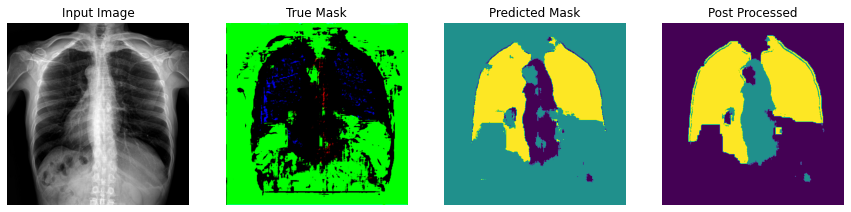

In [450]:
test_png_tf = tf.io.read_file("./Dataset/rayence_test/0206.jpg")
test_png_np = tf.image.decode_png(test_png_tf, channels=3).numpy()

norm = np.zeros((512,512,3))
norm_image = cv2.normalize(test_png_np, norm, 0,255,cv2.NORM_MINMAX)

original_size = list(original_size)[:2]
test_png_resize_tf = cv2.resize(norm_image, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)



predicted_mask = model.predict(tf.expand_dims(tf.convert_to_tensor(test_png_resize_tf), axis=0))
labeled_mask = create_mask(predicted_mask)

labeled_mask_array = labeled_mask.numpy().reshape(512, 512)
labeled_mask_array = labeled_mask_array.astype(np.uint8)

opened_mask_array = cv2.dilate(labeled_mask_array, cv2.getStructuringElement(cv2.MORPH_RECT, (10,10)))
closing_mask_array = cv2.morphologyEx(opened_mask_array, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)))
opened_mask_array = cv2.morphologyEx(closing_mask_array, cv2.MORPH_OPEN, np.ones((17, 17), np.uint8))

fill_cardiac = do_floodFIll(labeled_mask_array)
final_mask = overlay_cardiac_mask(opened_mask_array, fill_cardiac)

new_image = convert_to_3channel(final_mask, original_size=original_size)

filename = os.path.basename(test_png).replace(".jpg" ,"")
abs_filename = os.path.join(RESULT_DIR, filename)
display([test_png_resize_tf, predicted_mask[0], labeled_mask, final_mask])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


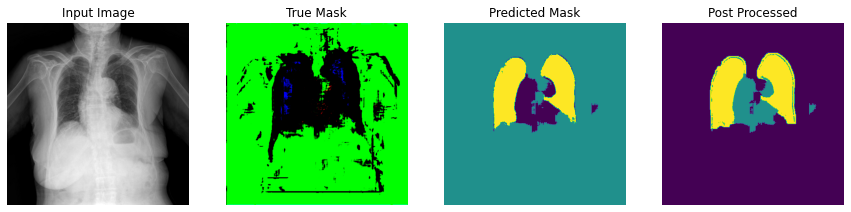

In [453]:
test_png = test_pngs[0]
test_png_tf = tf.io.read_file(test_png)
test_png_tf = tf.image.decode_png(test_png_tf, channels=3).numpy()
original_size = list(original_size)[:2]
test_png_resize_tf = cv2.resize(test_png_tf, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

predicted_mask = model.predict(tf.expand_dims(tf.convert_to_tensor(test_png_resize_tf), axis=0))
labeled_mask = create_mask(predicted_mask)

labeled_mask_array = labeled_mask.numpy().reshape(512, 512)
labeled_mask_array = labeled_mask_array.astype(np.uint8)

opened_mask_array = cv2.dilate(labeled_mask_array, cv2.getStructuringElement(cv2.MORPH_RECT, (10,10)))
closing_mask_array = cv2.morphologyEx(opened_mask_array, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)))
opened_mask_array = cv2.morphologyEx(closing_mask_array, cv2.MORPH_OPEN, np.ones((17, 17), np.uint8))

fill_cardiac = do_floodFIll(labeled_mask_array)
final_mask = overlay_cardiac_mask(opened_mask_array, fill_cardiac)

new_image = convert_to_3channel(final_mask, original_size=original_size)

filename = os.path.basename(test_png).replace(".jpg" ,"")
abs_filename = os.path.join(RESULT_DIR, filename)
np.save(abs_filename, new_image)

display([test_png_resize_tf, predicted_mask[0], labeled_mask, final_mask])

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0151.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


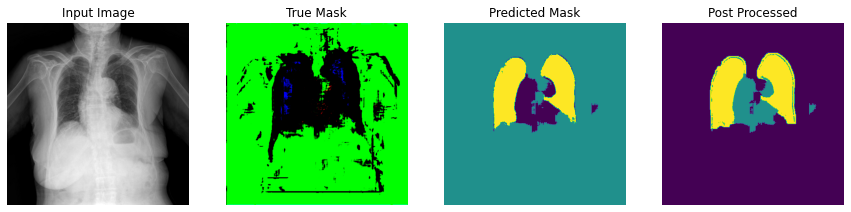

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0152.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


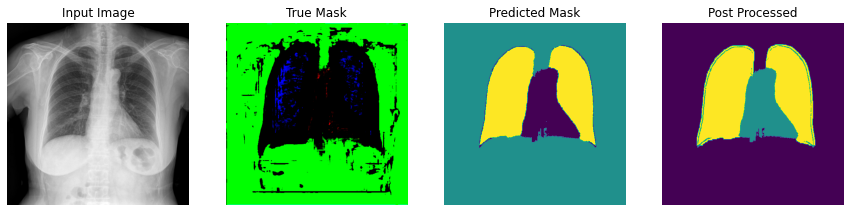

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0153.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


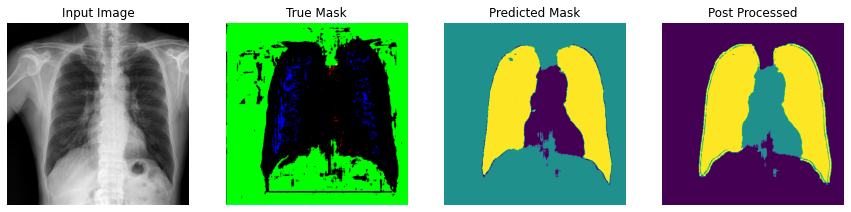

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0154.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


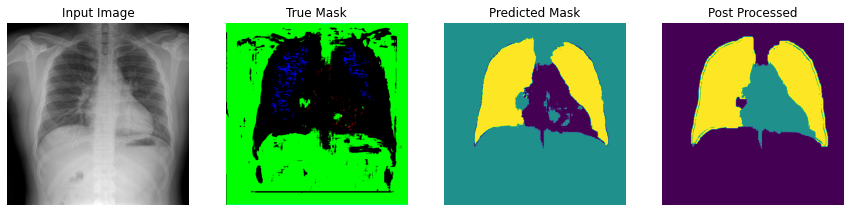

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0155.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


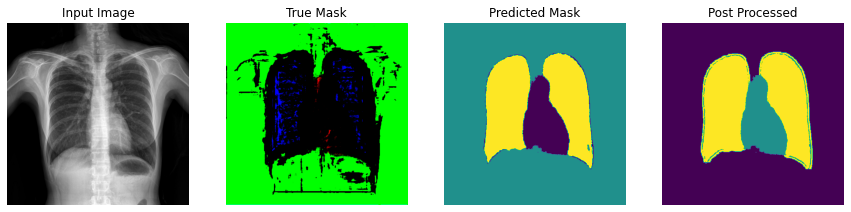

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0156.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


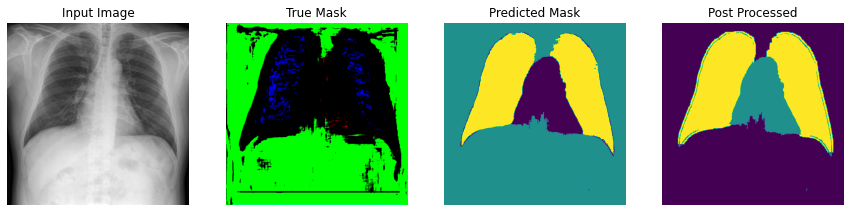

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0157.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


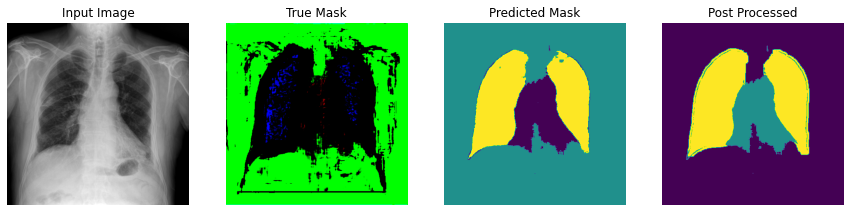

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0158.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


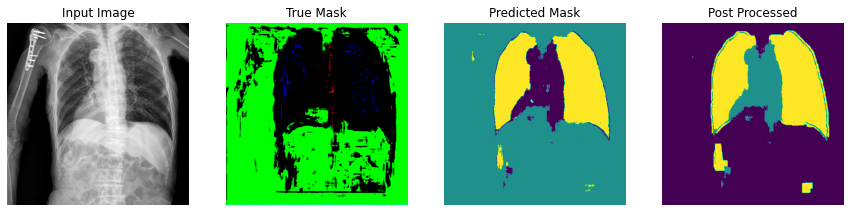

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0159.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


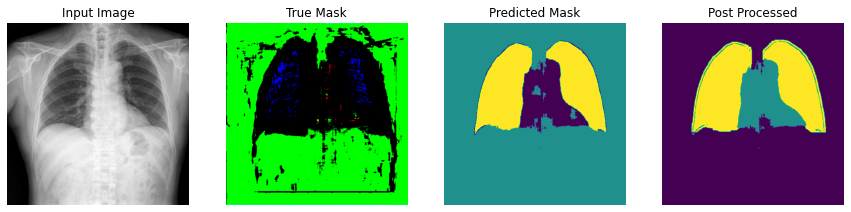

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0160.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


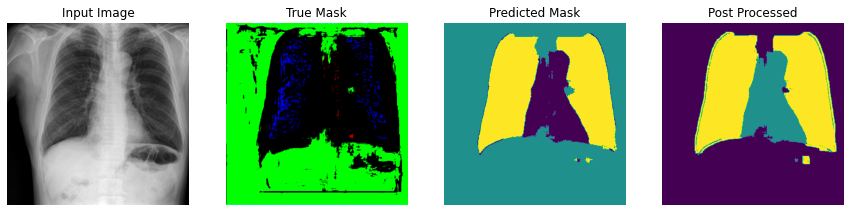

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0161.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


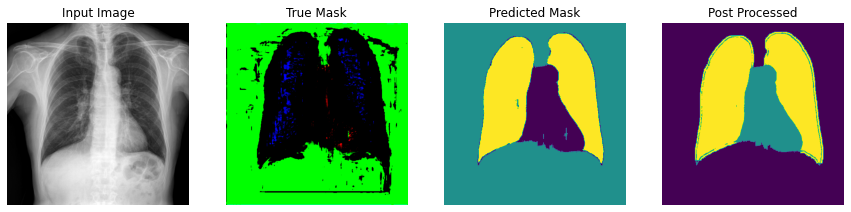

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0162.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


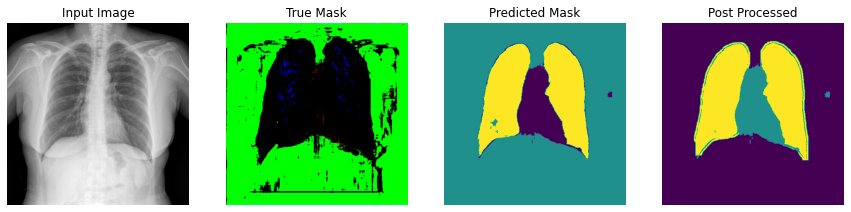

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0163.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


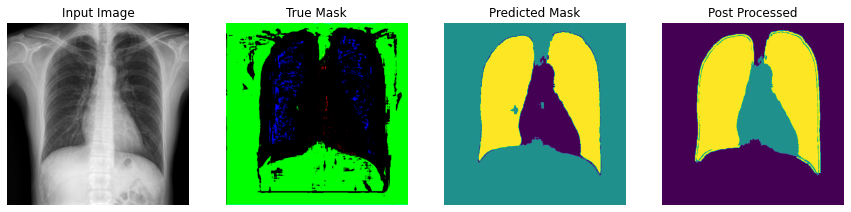

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0164.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


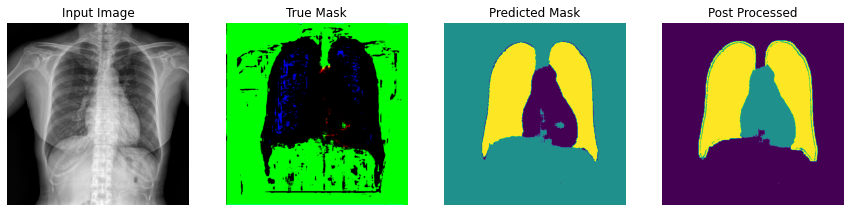

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0165.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


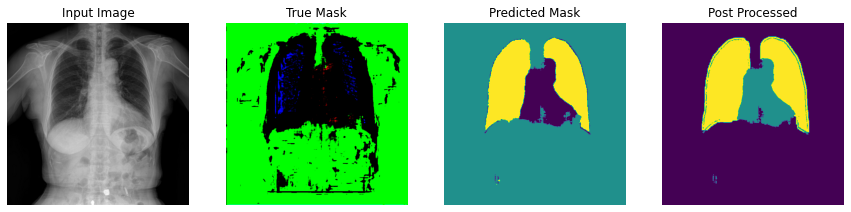

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0166.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


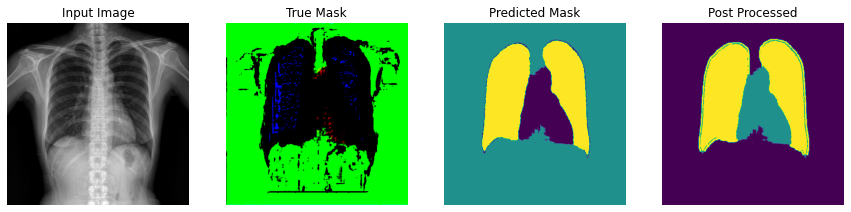

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0167.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


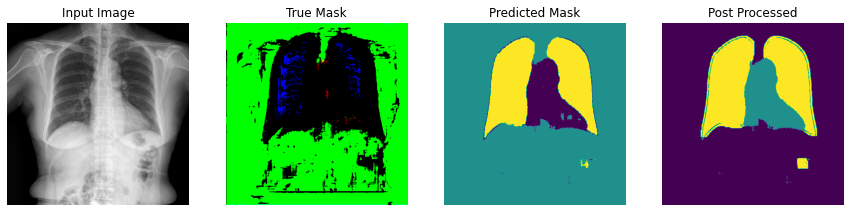

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0168.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


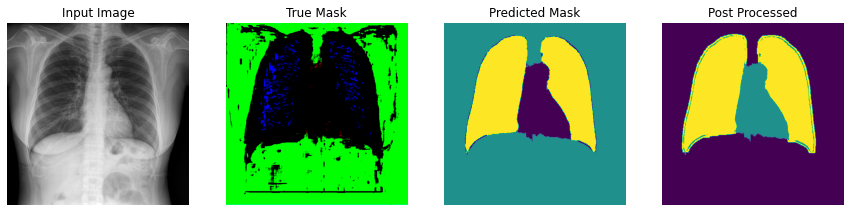

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0169.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


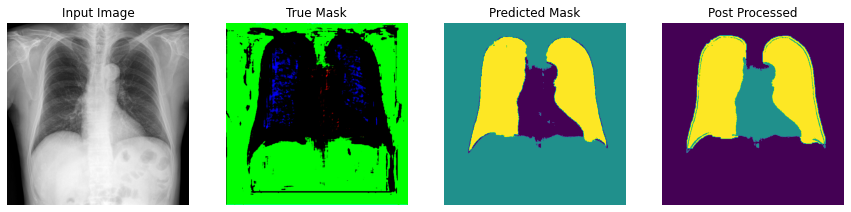

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0170.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


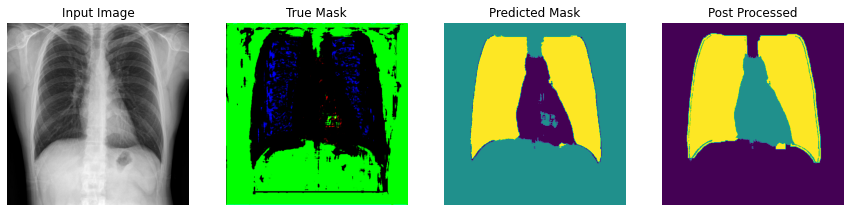

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0171.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


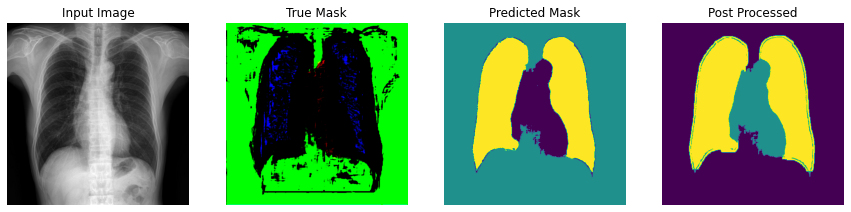

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0172.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


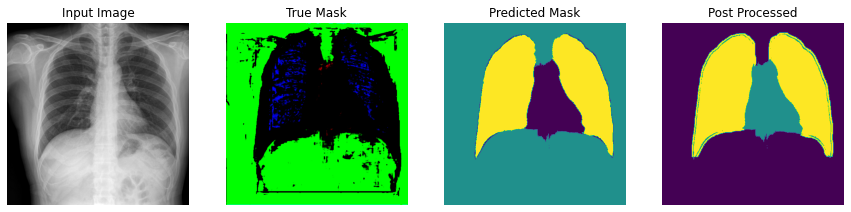

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0173.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


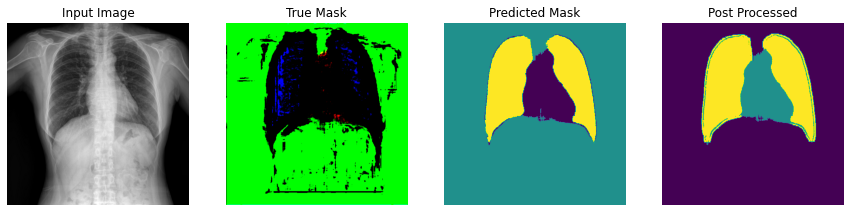

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0174.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


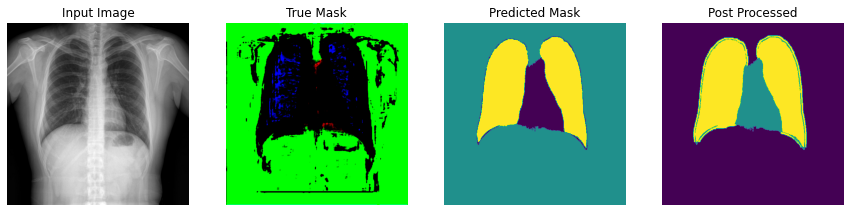

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0175.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


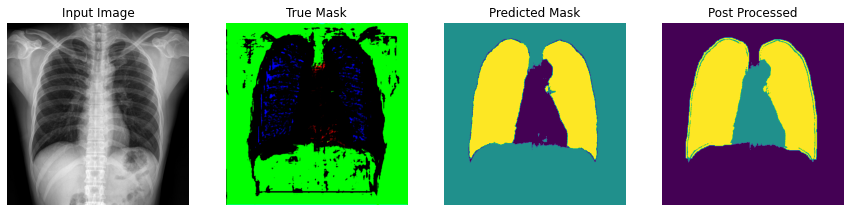

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0176.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


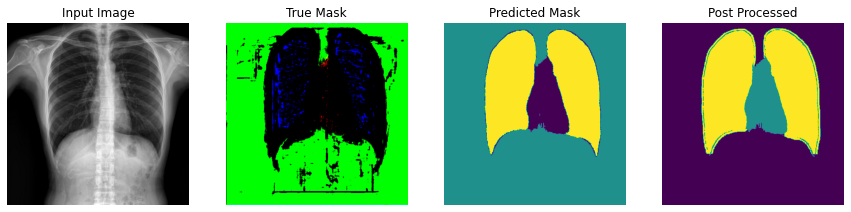

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0177.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


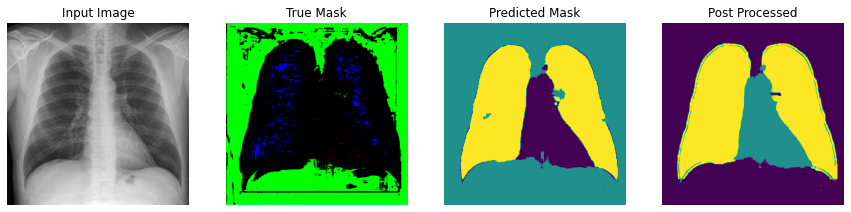

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0178.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


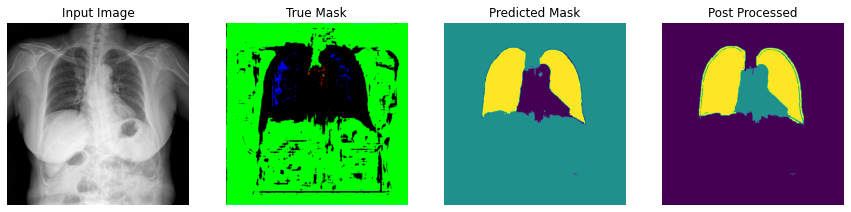

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0179.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


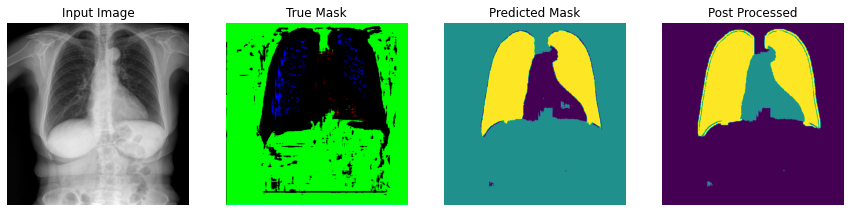

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0180.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


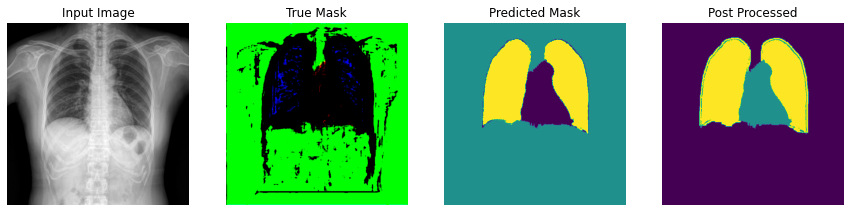

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0181.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


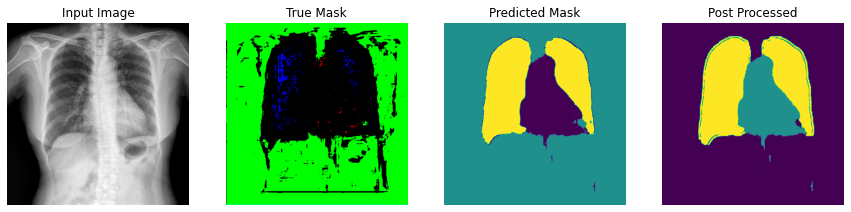

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0182.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


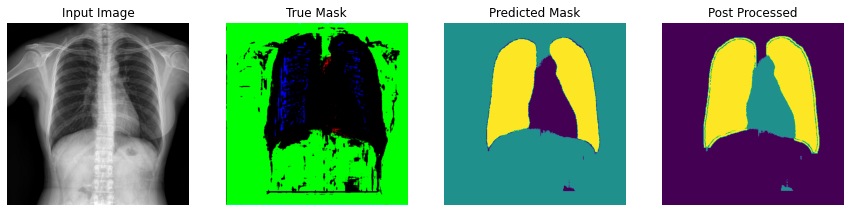

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0183.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


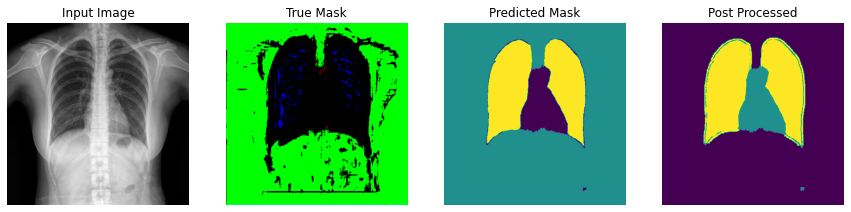

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0184.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


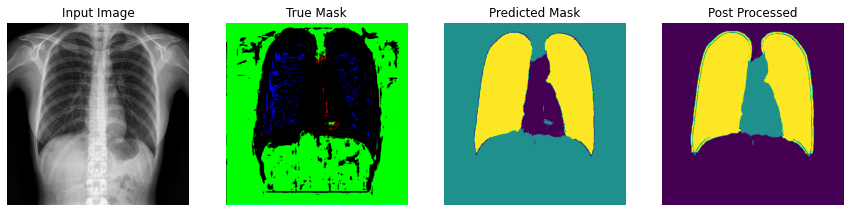

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0185.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


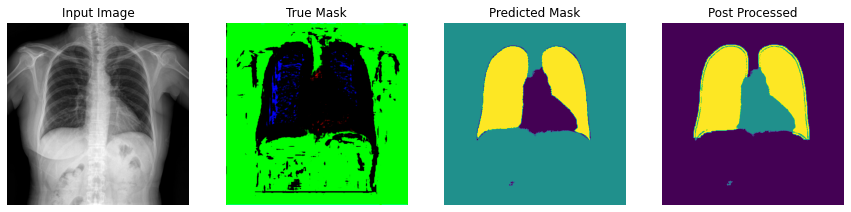

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0186.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


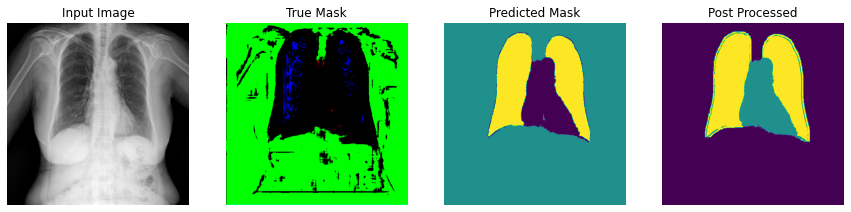

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0187.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


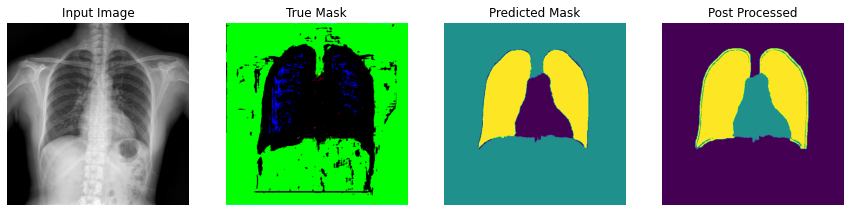

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0188.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


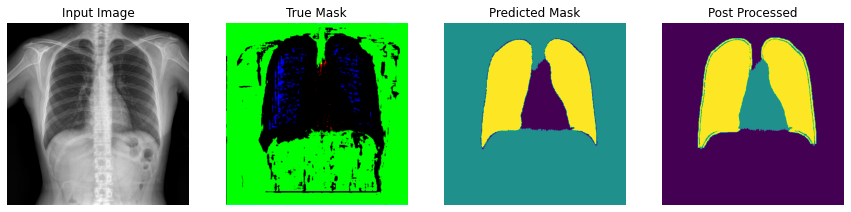

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0189.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


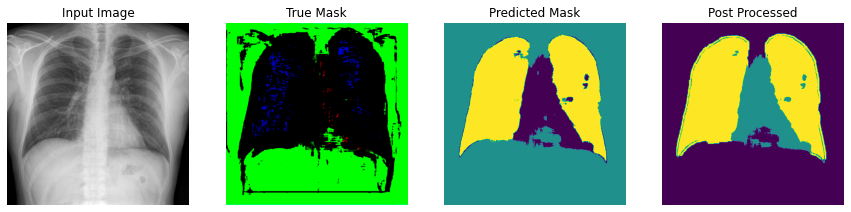

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0190.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


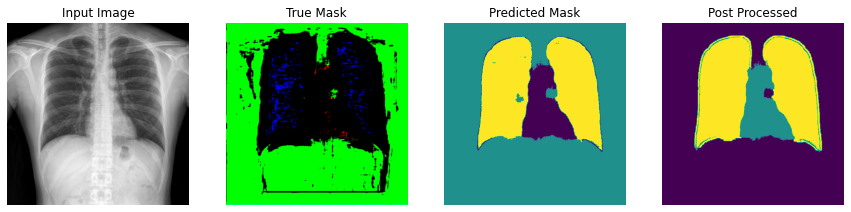

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0191.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


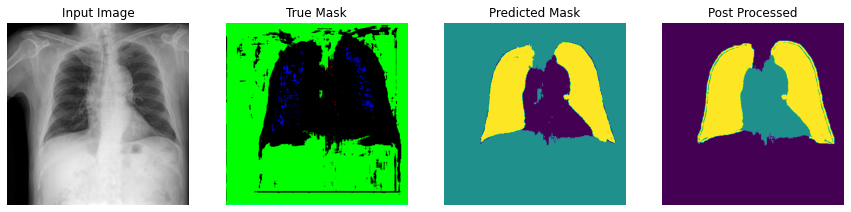

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0192.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


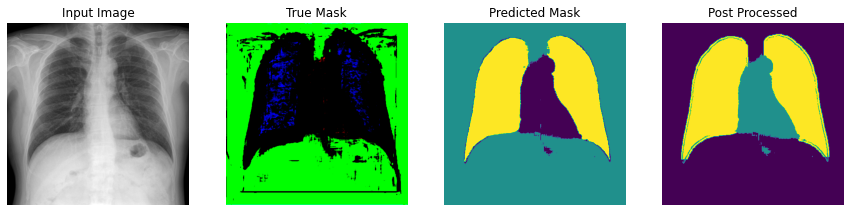

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0193.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


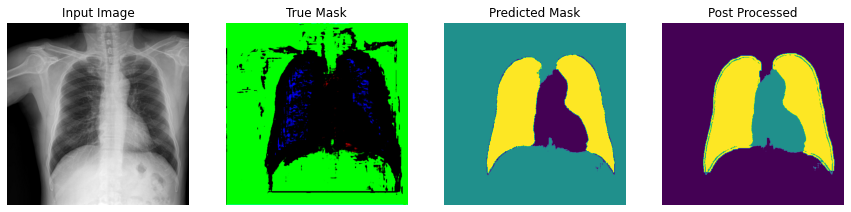

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0194.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


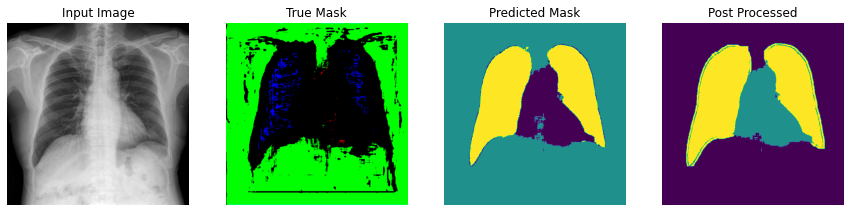

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0195.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


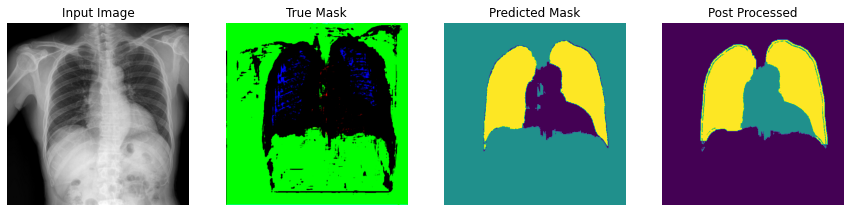

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0196.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


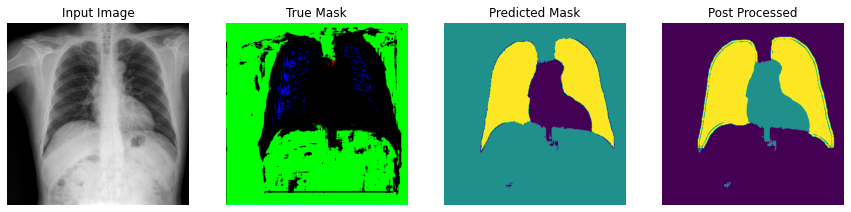

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0197.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


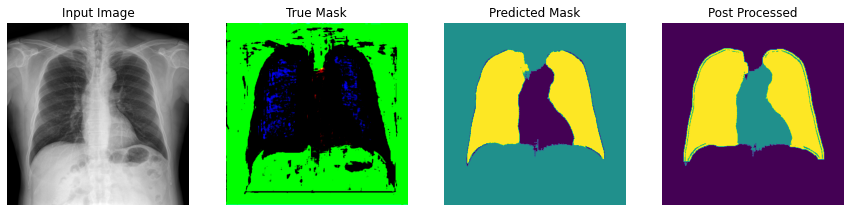

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0198.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


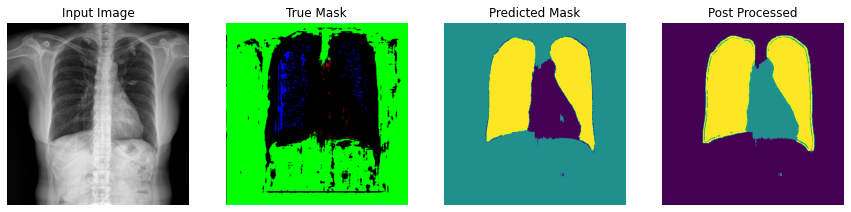

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0199.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


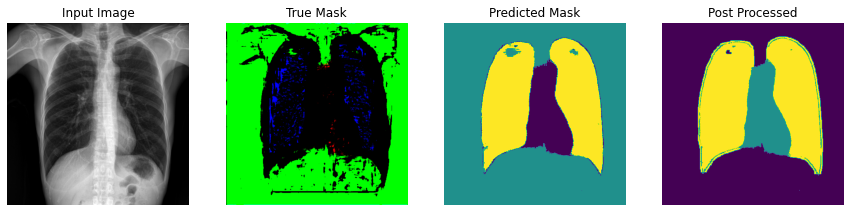

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0200.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


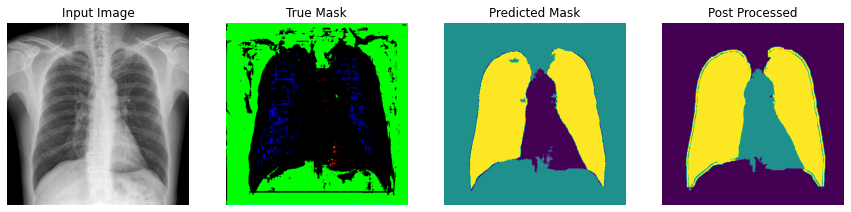

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0201.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


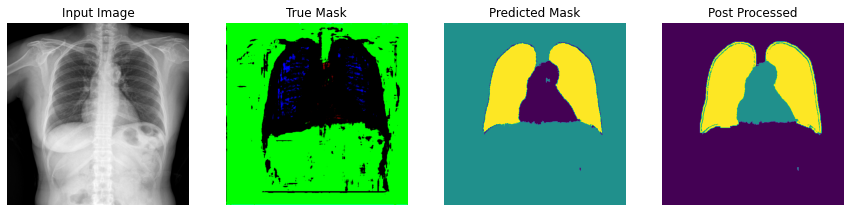

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0202.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


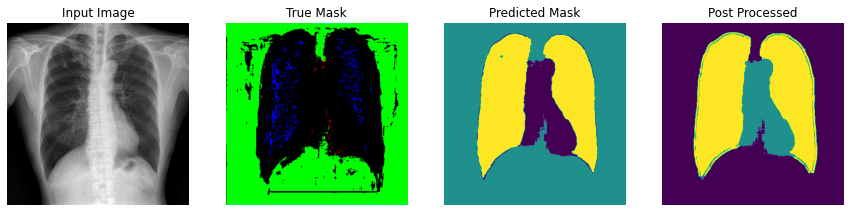

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0203.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


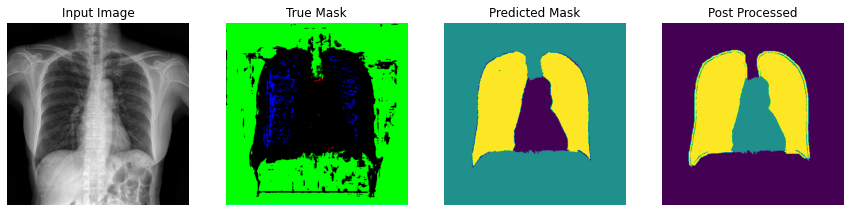

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0204.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


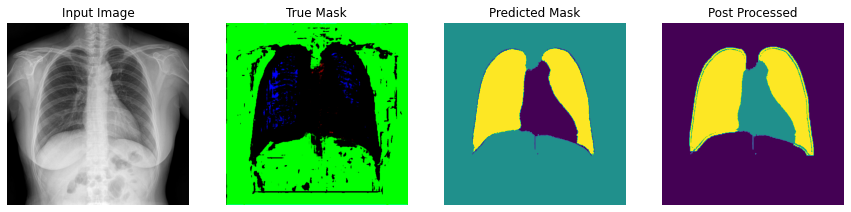

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0205.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


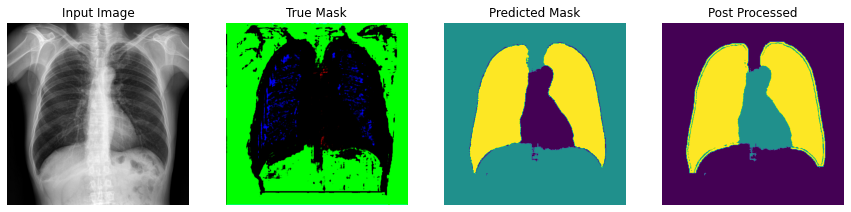

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0206.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


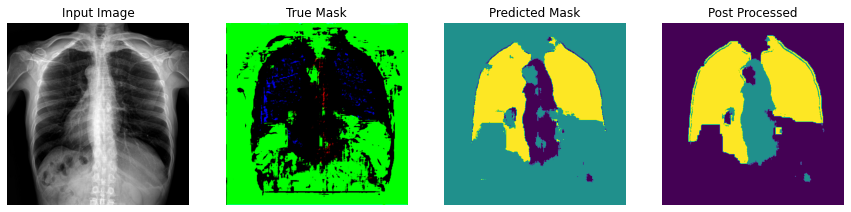

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0207.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


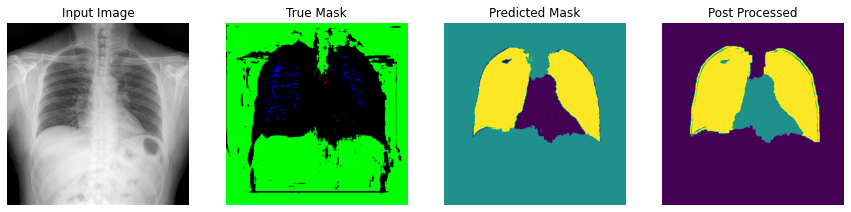

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0208.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


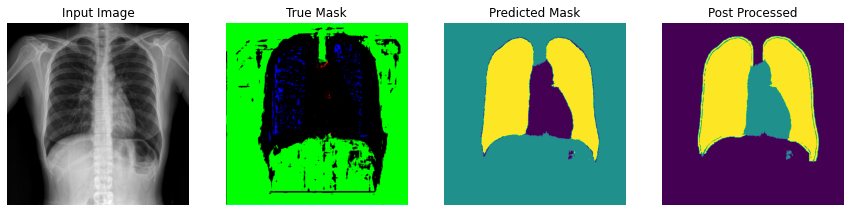

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0209.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


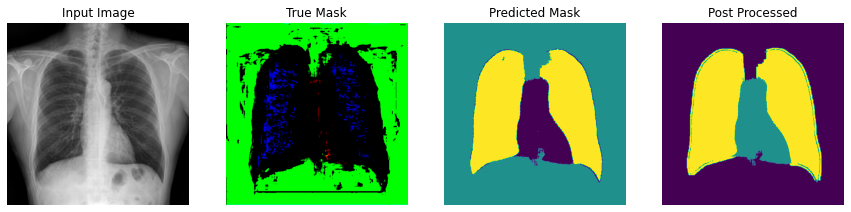

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0210.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


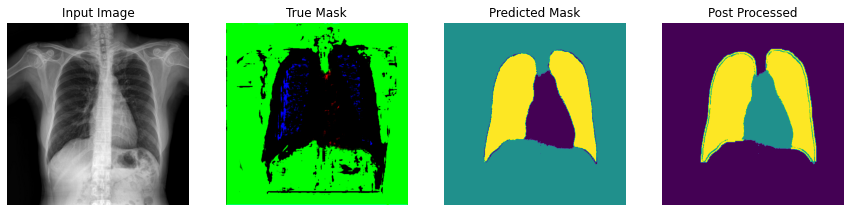

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0211.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


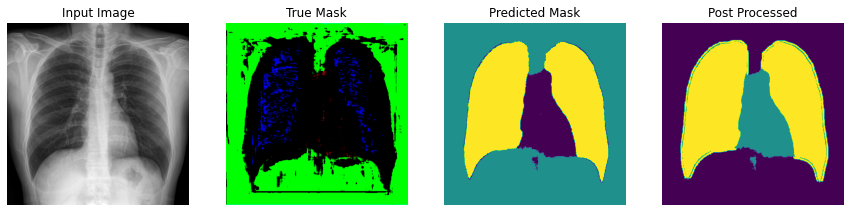

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0212.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


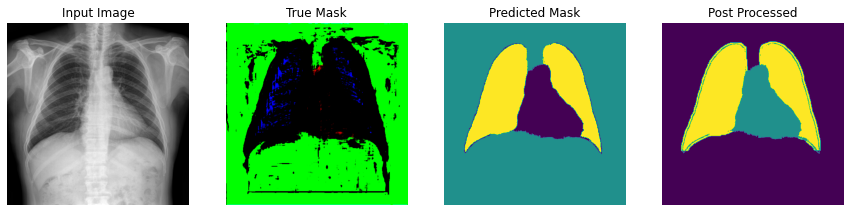

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0213.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


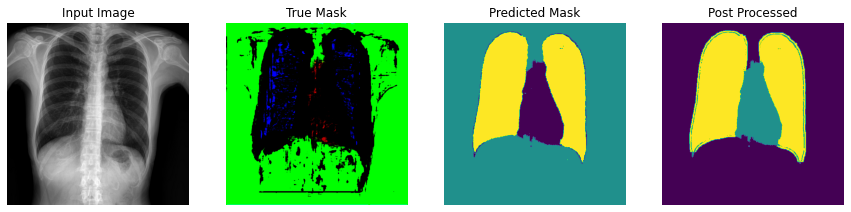

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0214.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


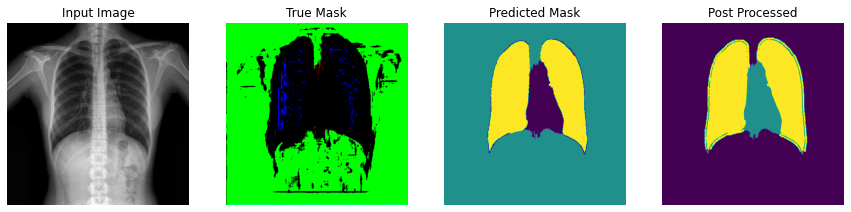

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0215.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


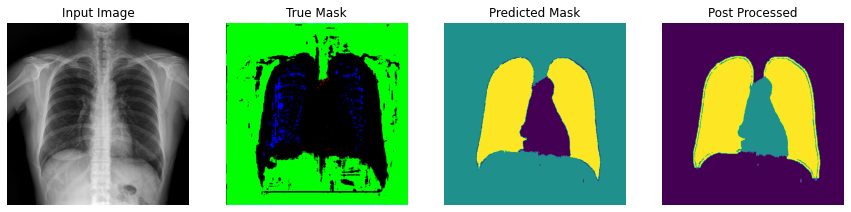

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0216.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


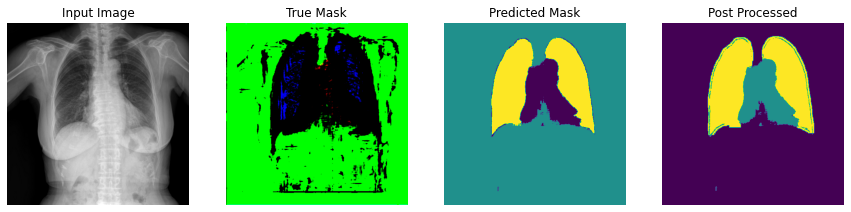

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0217.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


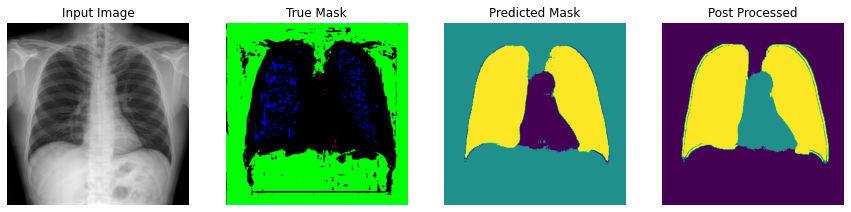

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0218.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


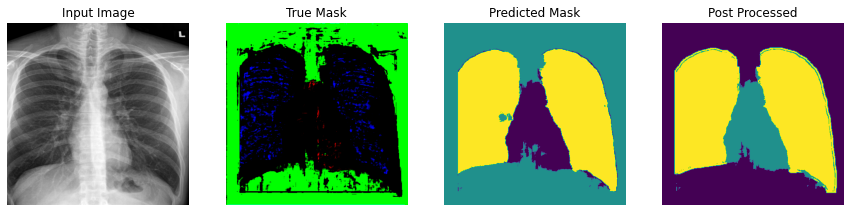

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0219.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


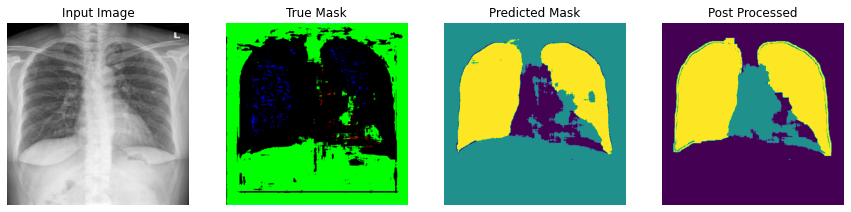

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0220.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


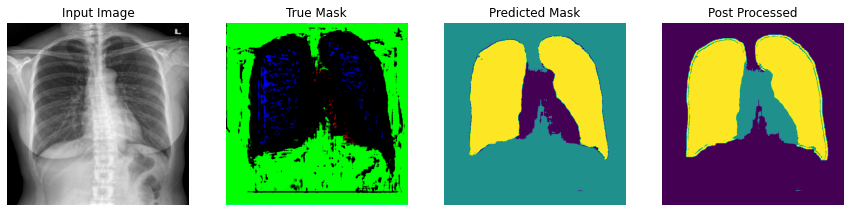

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0221.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


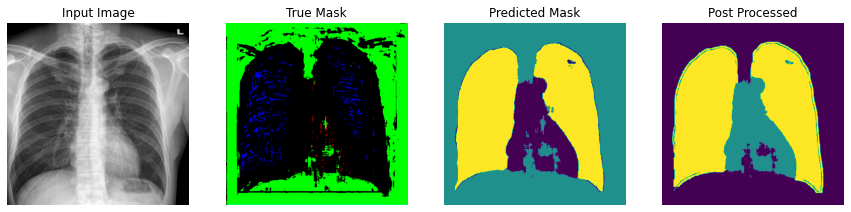

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0222.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


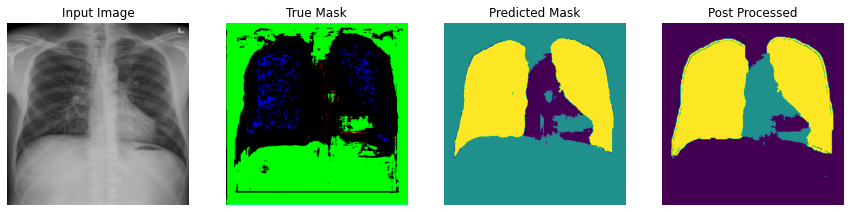

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0223.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


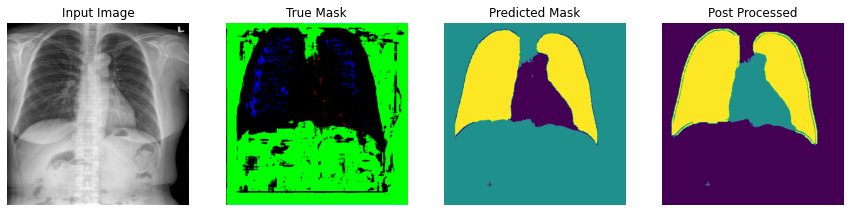

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0224.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


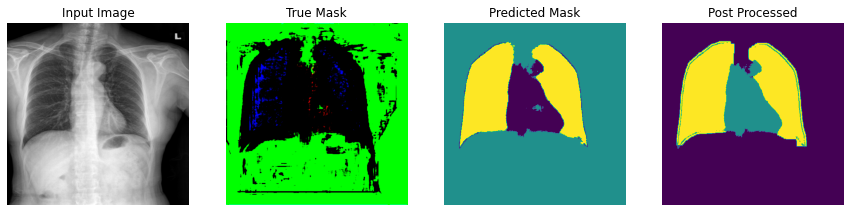

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0225.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


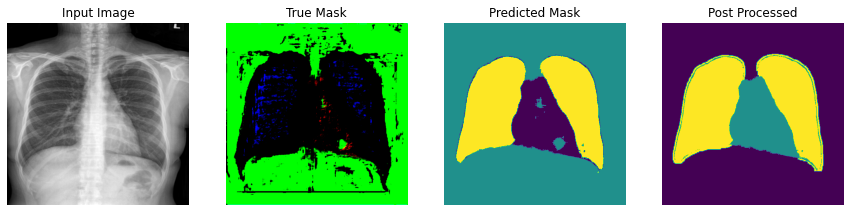

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0226.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


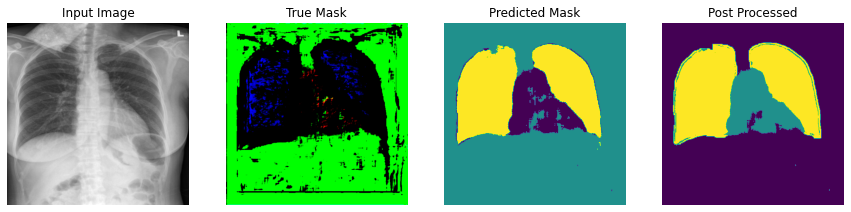

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0227.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


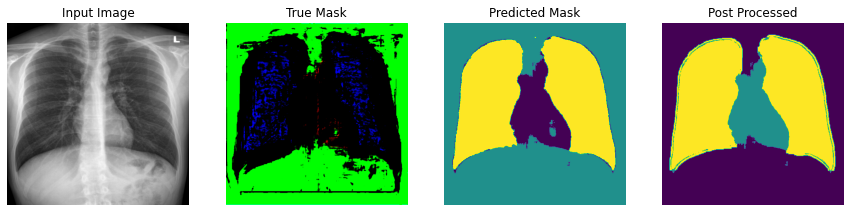

C:\Users\sosal\.jupyter\LungSegmentation\Dataset\rayence_test\0228.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


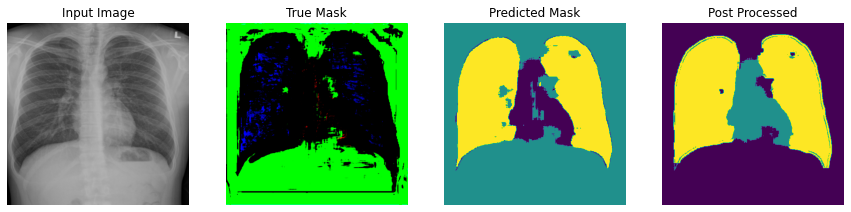

In [428]:
for test_png in test_pngs:
    print(test_png)
    test_png_tf = tf.io.read_file(test_png)
    test_png_tf = tf.image.decode_png(test_png_tf, channels=3).numpy()
    original_size = list(original_size)[:2]
    test_png_resize_tf = cv2.resize(test_png_tf, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

    predicted_mask = model.predict(tf.expand_dims(tf.convert_to_tensor(test_png_resize_tf), axis=0))
    labeled_mask = create_mask(predicted_mask)

    labeled_mask_array = labeled_mask.numpy().reshape(512, 512)
    labeled_mask_array = labeled_mask_array.astype(np.uint8)

    opened_mask_array = cv2.dilate(labeled_mask_array, cv2.getStructuringElement(cv2.MORPH_RECT, (10,10)))
    closing_mask_array = cv2.morphologyEx(opened_mask_array, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)))
    opened_mask_array = cv2.morphologyEx(closing_mask_array, cv2.MORPH_OPEN, np.ones((17, 17), np.uint8))

    fill_cardiac = do_floodFIll(labeled_mask_array)
    final_mask = overlay_cardiac_mask(opened_mask_array, fill_cardiac)
    
    new_image = convert_to_3channel(final_mask, original_size=original_size)
    
    filename = os.path.basename(test_png).replace(".jpg" ,"")
    abs_filename = os.path.join(RESULT_DIR, filename)
    np.save(abs_filename, new_image)

    display([test_png_resize_tf, predicted_mask[0], labeled_mask, final_mask])